<a href="https://colab.research.google.com/github/BRIAN12682/Automation-Projects/blob/main/ArchitecturesftGRADCAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Validation, training and test sets

In [ ]:
!pip install tensorflow

In [ ]:
import os
import cv2
import xml.etree.ElementTree as ET
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

dataset_folder = '/content/drive/MyDrive/Resized_Annotated_Folder'

def parse_xml_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    label = 0
    coordinates_list = []

    for object_element in root.findall('object'):
        bndbox = object_element.find('bndbox')

        if bndbox is not None:
            label = 1
            x = int(float(bndbox.find('xmin').text))
            y = int(float(bndbox.find('ymin').text))
            width = int(float(bndbox.find('xmax').text) - x)
            height = int(float(bndbox.find('ymax').text) - y)

            coordinates_list.append((x, y, width, height))

    return label, coordinates_list

images = []
annotations = []

for root_folder in os.listdir(dataset_folder):
    root_folder_path = os.path.join(dataset_folder, root_folder)

    if os.path.isdir(root_folder_path):
        label = 1 if root_folder == 'With_Bounding_Boxes' else 0

        for filename in os.listdir(root_folder_path):
            if filename.endswith('.jpg'):
                # Load image
                image_path = os.path.join(root_folder_path, filename)
                img = cv2.imread(image_path)
                images.append(img)

                 # Load corresponding XML annotation
                xml_filename = os.path.splitext(filename)[0] + '.xml'
                xml_path = os.path.join(dataset_folder, 'annotation', xml_filename)
                label, annotation = parse_xml_annotation(xml_path)
                annotations.append(label)

X = np.array(images)
y = np.array(annotations)


y_int = y.astype(int)

if np.sum(y_int == 0) == 0 or np.sum(y_int == 1) == 0:
    raise ValueError("Error: There are no samples for one or both classes. Check your data.")

# Counting the number of samples in each class
class_counts = np.bincount(y_int)

# Print class counts for debugging
print("Class Counts:", class_counts)
min_class_count = np.min(class_counts[class_counts > 0])
print("Minimum Class Count:", min_class_count)

test_size = int(min_class_count * 0.2)
train_size = min_class_count - test_size

indices_train, indices_val, y_train, y_val = train_test_split(
    np.arange(len(X)),
    y_int,
    test_size=test_size,
    train_size=train_size,
    stratify=y_int,
    random_state=42
)

X_train, X_val = X[indices_train], X[indices_val]



ValueError: Error: There are no samples for one or both classes. Check your data.

In [ ]:
import os
import cv2
import xml.etree.ElementTree as ET
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

dataset_folder = '/content/drive/MyDrive/images'

# SAVING THE SETS

In [ ]:

save_path = '/content/drive/MyDrive/DATASETS/Annotated_Folder/'

# Save images and annotations
np.save(os.path.join(save_path, 'X.npy'), X)
np.save(os.path.join(save_path, 'y.npy'), y)

# Save train-test split indices
np.save(os.path.join(save_path, 'indices_train.npy'), indices_train)
np.save(os.path.join(save_path, 'indices_val.npy'), indices_val)

# LOADING THE SETS

In [ ]:
from tensorflow.keras.models import save_model
import numpy as np
import os
load_path = '/content/drive/MyDrive/Resized_Annotated_Folder/'

# Load images and annotations
X = np.load(os.path.join(load_path, 'X.npy'))
y = np.load(os.path.join(load_path, 'y.npy'))

# Load train-test split indices
indices_train = np.load(os.path.join(load_path, 'indices_train.npy'))
indices_val = np.load(os.path.join(load_path, 'indices_val.npy'))


# MOBILE NET

In [ ]:
# from tensorflow.keras.applications import MobileNet
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Conv2D, MaxPooling2D, Flatten

# def create_mobilenet_branch(input_shape=(256, 256, 3), save_path='mobilenet_branch_model.h5'):
#     mobilenet_model = MobileNet(input_shape=input_shape, include_top=False, weights='imagenet')
#     for layer in mobilenet_model.layers:
#         layer.trainable = True

#     model = Sequential()
#     model.add(mobilenet_model)
#     # Add Conv2D and MaxPooling2D layers after the MobileNet model
#     model.add(Conv2D(64, (3, 3), activation='relu'))
#     model.add(MaxPooling2D((2, 2)))

#     model.add(Conv2D(128, (3, 3), activation='relu',  padding='same'))
#     model.add(MaxPooling2D((2, 2)))

#     # Global Average Pooling layer to reduce spatial dimensions
#     model.add(GlobalAveragePooling2D())

#     # Dense layers for classification
#     model.add(Dense(128, activation='relu'))
#     model.add(Dense(1, activation='sigmoid'))
#     model.save(save_path)

#     return model
# mobilenet_branch_save_path = '/content/drive/MyDrive/Resized_Annotated_Folder/mobilenet_branch_model.h5'
# mobilenet_branch = create_mobilenet_branch(save_path=mobilenet_branch_save_path)

# mobilenet_branch.summary()


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, DepthwiseConv2D, BatchNormalization, ReLU, GlobalAveragePooling2D, Dense

def MobileNet(input_shape=(224, 224, 3), alpha=1.0, num_classes=2):
    """
    MobileNetV1 implementation.

    Parameters:
    - input_shape: Input shape of the images (height, width, channels).
    - alpha: Width multiplier to reduce the number of filters. It should be between 0 and 1.
    - num_classes: Number of output classes.

    Returns:
    - Keras Model instance.
    """
    # Input layer
    input_tensor = Input(shape=input_shape)

    # Depthwise separable convolution block
    def depthwise_separable_conv(x, filters, alpha, kernel=(3, 3), strides=(1, 1)):
        filters = int(filters * alpha)

        x = DepthwiseConv2D(kernel_size=kernel, strides=strides, padding='same')(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)

        x = Conv2D(filters, (1, 1), strides=(1, 1), padding='same')(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)

        return x

    # MobileNet architecture
    x = Conv2D(int(32 * alpha), (3, 3), strides=(2, 2), padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = depthwise_separable_conv(x, 64, alpha)
    x = depthwise_separable_conv(x, 128, alpha, strides=(2, 2))
    x = depthwise_separable_conv(x, 128, alpha)

    x = depthwise_separable_conv(x, 256, alpha, strides=(2, 2))
    x = depthwise_separable_conv(x, 256, alpha)

    x = depthwise_separable_conv(x, 512, alpha, strides=(2, 2))
    for _ in range(5):
        x = depthwise_separable_conv(x, 512, alpha)

    x = depthwise_separable_conv(x, 1024, alpha, strides=(2, 2))
    x = depthwise_separable_conv(x, 1024, alpha)

    # Global average pooling and dense output layer
    x = GlobalAveragePooling2D()(x)
    x = Dense(num_classes, activation='softmax')(x)

    # Create and return the model
    model = Model(inputs=input_tensor, outputs=x, name='MobileNet')
    return model

# Example usage
input_shape = (224, 224, 3)
num_classes = 1000
mobile_net_model = MobileNet(input_shape=input_shape, alpha=1.0, num_classes=num_classes)

# Print the model summary
mobile_net_model.summary()


Model: "MobileNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 112, 112, 32)      128       
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 112, 112, 32)      0         
                                                                 
 depthwise_conv2d (Depthwis  (None, 112, 112, 32)      320       
 eConv2D)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 112, 112, 32)      12

In [ ]:
!pip install tensorflow

In [ ]:
# Assuming you've already loaded your datasets (cnn_branch_X_train, cnn_branch_y_train, cnn_branch_X_val, cnn_branch_y_val)
from tensorflow.keras.models import load_model

# MobileNet Branch
mobilenet_branch_X_train = X_train
mobilenet_branch_y_train = y_train
mobilenet_branch_X_val = X_val
mobilenet_branch_y_val = y_val


mobilenet_model_path = '/content/drive/MyDrive/Resized_Annotated_Folder/mobilenet_branch_model.h5'
mobilenet_model = load_model(mobilenet_model_path)

# Compile the MobileNet model
mobilenet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the MobileNet model
mobilenet_model.fit(mobilenet_branch_X_train, mobilenet_branch_y_train, validation_data=(mobilenet_branch_X_val, mobilenet_branch_y_val), epochs=10, batch_size=32)


Epoch 1/10
8/8 [==============================] - 22s 488ms/step - loss: 0.5637 - accuracy: 0.8246 - val_loss: 0.5065 - val_accuracy: 0.8929
Epoch 2/10
8/8 [==============================] - 1s 107ms/step - loss: 0.0741 - accuracy: 0.9561 - val_loss: 0.5261 - val_accuracy: 0.8929
Epoch 3/10
8/8 [==============================] - 1s 106ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.3714 - val_accuracy: 0.9286
Epoch 4/10
8/8 [==============================] - 1s 108ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.4560 - val_accuracy: 0.9643
Epoch 5/10
8/8 [==============================] - 1s 101ms/step - loss: 7.8738e-04 - accuracy: 1.0000 - val_loss: 0.5599 - val_accuracy: 0.9286
Epoch 6/10
8/8 [==============================] - 1s 100ms/step - loss: 3.1293e-04 - accuracy: 1.0000 - val_loss: 0.0460 - val_accuracy: 0.9821
Epoch 7/10
8/8 [==============================] - 1s 102ms/step - loss: 0.0070 - accuracy: 0.9956 - val_loss: 0.0407 - val_accuracy: 0.9821
Epoch 8/10


In [ ]:
from sklearn.metrics import classification_report, accuracy_score

mobilenet_predictions = mobilenet_model.predict(mobilenet_branch_X_val)
mobilenet_predictions = (mobilenet_predictions > 0.5).astype(int)

# Calculate metrics
accuracy = accuracy_score(mobilenet_branch_y_val, mobilenet_predictions)
classification_report_output = classification_report(mobilenet_branch_y_val, mobilenet_predictions, target_names=['Class 0', 'Class 1'])

# Print the metrics
print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:\n', classification_report_output)


2/2 [==============================] - 5s 2s/step
Accuracy: 0.9286
Classification Report:
               precision    recall  f1-score   support

     Class 0       1.00      0.33      0.50         6
     Class 1       0.93      1.00      0.96        50

    accuracy                           0.93        56
   macro avg       0.96      0.67      0.73        56
weighted avg       0.93      0.93      0.91        56



2/2 [==============================] - 6s 3s/step


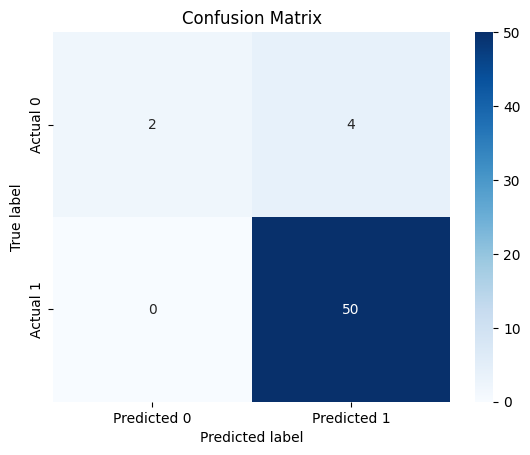

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you've already loaded your datasets (mobilenet_branch_X_val, mobilenet_branch_y_val)

# Evaluate the MobileNet model on the validation set
mobilenet_predictions = mobilenet_model.predict(mobilenet_branch_X_val)
mobilenet_predictions = (mobilenet_predictions > 0.5).astype(int)  # Convert probabilities to binary predictions

# Calculate the confusion matrix
conf_matrix = confusion_matrix(mobilenet_branch_y_val, mobilenet_predictions)

# Plot the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from tensorflow.keras.models import load_model

mobilenet_model_path = '/content/drive/MyDrive/Resized_Annotated_Folder/mobilenet_branch_model.h5'
mobilenet_model = load_model(mobilenet_model_path)

mobilenet_model.summary()

last_layer_name = mobilenet_model.layers[-1].name
print("Last Layer Name:", last_layer_name)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)        3228864   
 onal)                                                           
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 64)          589888    
                                                                 
 max_pooling2d (MaxPooling2  (None, 2, 2, 64)          0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 2, 128)         73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 1, 1, 128)         0         
 g2D)                                                            
                                                        

In [ ]:
!pip install tensorflow

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet import preprocess_input
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load your custom MobileNet-based model
mobilenet_model_path = '/content/drive/MyDrive/Resized_Annotated_Folder/mobilenet_branch_model.h5'
mobilenet_model = load_model(mobilenet_model_path)

dir_path = '/content/drive/MyDrive/Resized_Annotated_Folder/With_Bounding_Boxes'
files = os.listdir(dir_path)

# Process the first five images
for i, file in enumerate(files[:5]):
    img_path = os.path.join(dir_path, file)

    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    last_conv_layer = mobilenet_model.get_layer('conv2d')

    grad_model = tf.keras.models.Model([mobilenet_model.inputs], [last_conv_layer.output, mobilenet_model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(x)
        loss = predictions[:, np.argmax(predictions[0])]

    grads = tape.gradient(loss, conv_outputs)[0]

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    cam = np.dot(conv_outputs[0], pooled_grads.numpy())

    cam = cv2.resize(cam, (224, 224))
        # Assuming `cam` calculation is done and cam is a 2D array
    cam = np.maximum(cam, 0)  # ReLU function
    cam = cam / np.max(cam)  # Normalize to 0-1 range
    cam = np.uint8(255 * cam)  # Scale to 0-255 range for applying colormap

    # Apply colormap directly without conversion to grayscale
    heatmap = cv2.applyColorMap(cam, cv2.COLORMAP_JET)

    # Superimpose heatmap on original image
    original_img = np.uint8(img)  # Ensure original image is prepared for superimposition
    superimposed_img = cv2.addWeighted(original_img, 0.6, heatmap, 0.4, 0)

    # Visualization
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title('Original Image')
    plt.subplot(1, 3, 2)
    plt.imshow(heatmap)
    plt.title('Grad-CAM')
    plt.subplot(1, 3, 3)
    plt.imshow(superimposed_img)
    plt.title('Superimposed Image')
    plt.show()


error: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/colormap.cpp:736: error: (-5:Bad argument) cv::ColorMap only supports source images of type CV_8UC1 or CV_8UC3 in function 'operator()'


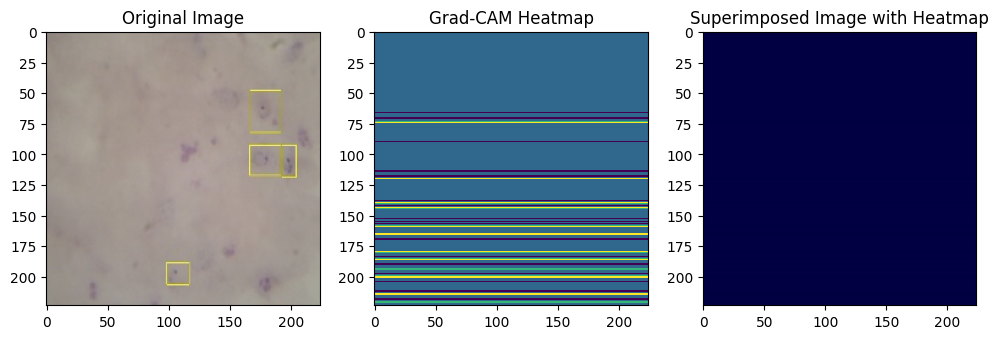

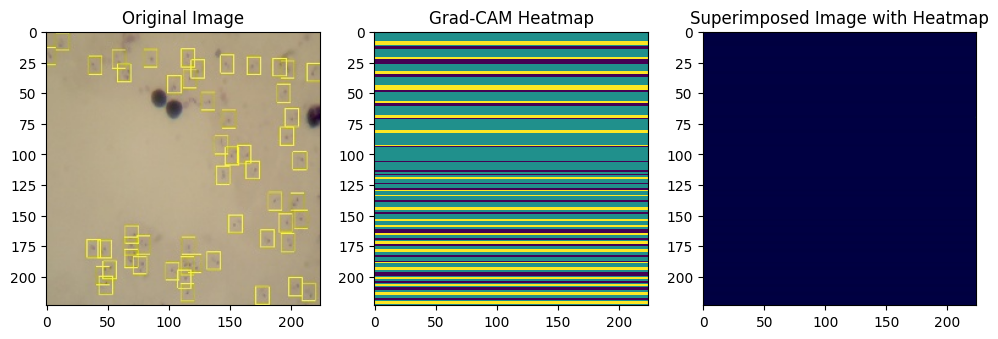

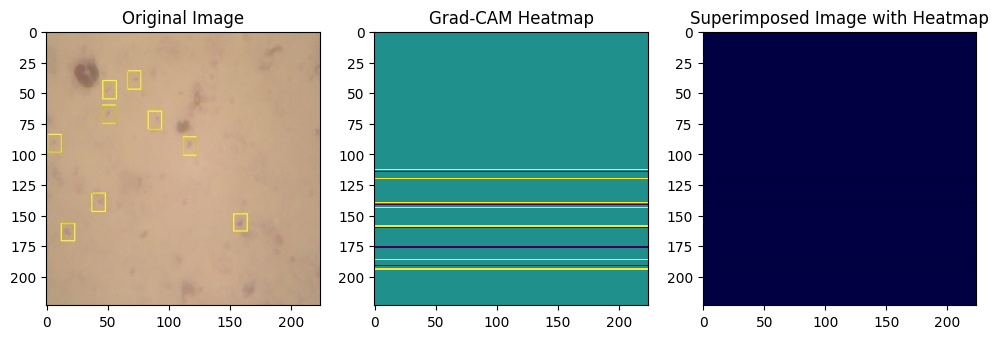

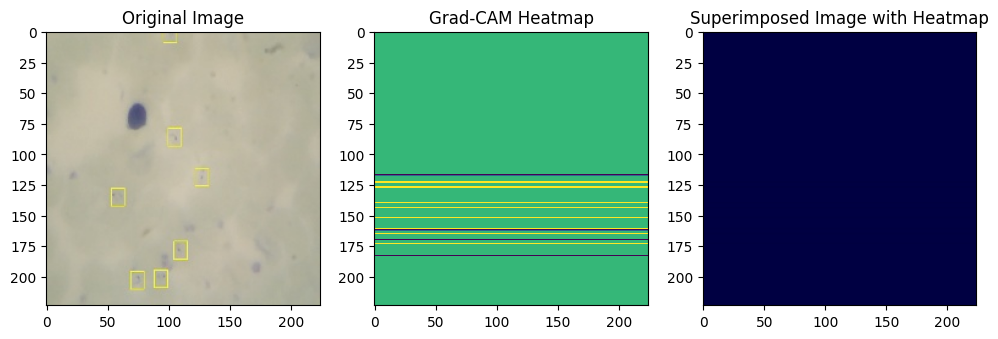

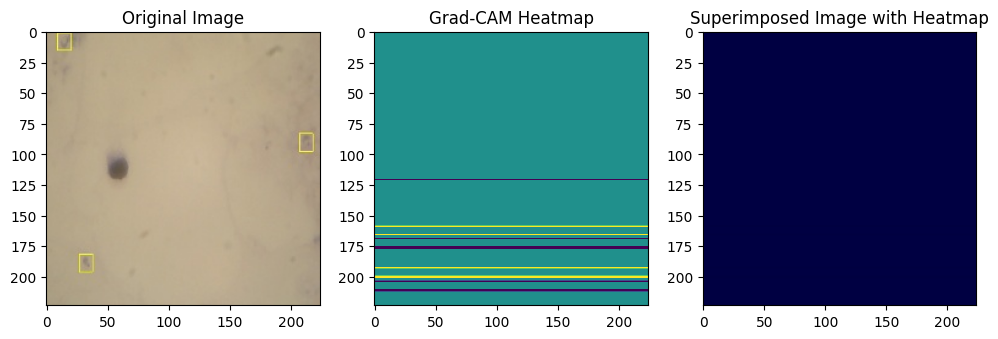

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet import preprocess_input
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

mobilenet_model_path = '/content/drive/MyDrive/Resized_Annotated_Folder/mobilenet_branch_model.h5'
mobilenet_model = load_model(mobilenet_model_path)

dir_path = '/content/drive/MyDrive/Resized_Annotated_Folder/With_Bounding_Boxes'
files = os.listdir(dir_path)

# Process the first five images
for i, file in enumerate(files[:5]):
    img_path = os.path.join(dir_path, file)

    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    last_conv_layer = mobilenet_model.get_layer('dense_1')

    grad_model = tf.keras.models.Model([mobilenet_model.inputs], [last_conv_layer.output, mobilenet_model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(x)
        loss = predictions[:, np.argmax(predictions[0])]

    # ... (previous code)

    grads = tape.gradient(loss, conv_outputs)[0]

    weights = tf.reduce_mean(grads)

    cam = np.dot(conv_outputs[0], weights.numpy())
    cam = cv2.resize(cam, (224, 224))
    cam = np.maximum(cam, 0)

    # Normalize the Grad-CAM values
    cam = cam / cam.max()

    # Adjust the saturation of the heatmap
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)

    # ... (remaining code)

    original_img_uint8 = np.uint8(x[0])
    heatmap_uint8 = np.uint8(heatmap)
    superimposed_img = cv2.addWeighted(original_img_uint8, 0.5, heatmap_uint8, 0.5, 0)

    # Display the images
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(cam, cmap='viridis')
    plt.title('Grad-CAM Heatmap')

    plt.subplot(1, 3, 3)
    plt.imshow(superimposed_img)
    plt.title('Superimposed Image with Heatmap')

    plt.show()  # Display the visualization


#NEW MOBILE NET


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

# Load the MobileNetV2 model, without the top layer, as we'll add our own classifier
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

# Add custom layers on top for our specific task
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)  # Example: a dense layer with 1024 units
predictions = Dense(10, activation='softmax')(x)  # Assuming we have 10 classes

# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model (example)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary to verify architecture
model.summary()


9406464/9406464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (N

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.model_selection import train_test_split

# Assuming X_train, X_val, y_train, y_val are loaded and prepared from your provided code

# Preprocess the images to match MobileNetV2's expected input
def preprocess_images(image_set):
    return np.array([tf.keras.applications.mobilenet_v2.preprocess_input(img) for img in image_set])

X_train_preprocessed = preprocess_images(X_train)
X_val_preprocessed = preprocess_images(X_val)

# Convert labels to categorical (one-hot encoding)
y_train_categorical = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_val_categorical = tf.keras.utils.to_categorical(y_val, num_classes=2)

# Define the MobileNetV2 model
def build_model(num_classes):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False  # Freeze the base model

    inputs = Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

model = build_model(num_classes=2)  # Assuming binary classification

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model training
model.fit(X_train_preprocessed, y_train_categorical, batch_size=32, epochs=10, validation_data=(X_val_preprocessed, y_val_categorical))


Epoch 1/10
8/8 [==============================] - 18s 2s/step - loss: 0.8739 - accuracy: 0.7851 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 2/10
8/8 [==============================] - 12s 2s/step - loss: 0.0715 - accuracy: 0.9737 - val_loss: 0.0976 - val_accuracy: 0.9286
Epoch 3/10
8/8 [==============================] - 11s 1s/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 4.0252e-05 - val_accuracy: 1.0000
Epoch 4/10
8/8 [==============================] - 10s 1s/step - loss: 0.0062 - accuracy: 0.9956 - val_loss: 3.9408e-05 - val_accuracy: 1.0000
Epoch 5/10
8/8 [==============================] - 12s 1s/step - loss: 2.1788e-04 - accuracy: 1.0000 - val_loss: 0.0019 - val_accuracy: 1.0000
Epoch 6/10
8/8 [==============================] - 21s 3s/step - loss: 0.0057 - accuracy: 0.9956 - val_loss: 0.0207 - val_accuracy: 1.0000
Epoch 7/10
8/8 [==============================] - 18s 2s/step - loss: 0.0039 - accuracy: 0.9956 - val_loss: 0.0098 - val_accuracy: 1.0000
Epoch 8/10
8/8 [======

In [ ]:
!pip install tensorflow


In [ ]:
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import LabelEncoder
import os
import matplotlib.pyplot as plt
import tensorflow
from tensorflow.keras import Sequential,Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from pathlib import Path
from tensorflow.keras.utils import image_dataset_from_directory
import seaborn as sns

In [ ]:
!pip install tf_keras_vis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 kB 648.6 kB/s eta 0:00:00


#DENSE NET

In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

def create_densenet_branch(input_shape=(224, 224, 3), num_classes=1, fine_tune_at=100):
    # Load the DenseNet121 model
    input_tensor = Input(shape=input_shape)
    base_model = DenseNet121(include_top=False, weights='imagenet', input_tensor=input_tensor)

    # Freeze all the layers before the 'fine_tune_at' layer
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

    # Adding custom layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    output_tensor = Dense(num_classes, activation='sigmoid' if num_classes == 1 else 'softmax')(x)

    model = Model(inputs=input_tensor, outputs=output_tensor)

    return model

# Example usage
densenet_branch = create_densenet_branch(input_shape=(256, 256, 3), num_classes=1)
densenet_branch.summary()
densenet_branch.save('/content/drive/MyDrive/Resized_Annotated_Folder/densenet1_branch_model.h5')


29084464/29084464 [==============================] - 2s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 262, 262, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 128, 128, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
!pip install tensorflow
!pip install numpy scikit-learn opencv-python matplotlib


In [ ]:
import tensorflow as tf
# Define directories for training and validation data
train_dir = '/content/drive/MyDrive/DATASETS/Annotated_Folder/train'
val_dir = '/content/drive/MyDrive/DATASETS/Annotated_Folder/val'

# Data generators for loading images
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input,
    horizontal_flip=True,
    vertical_flip=True
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary'
    #if num_classes == 2 else 'categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary'
    #if num_classes == 2 else 'categorical'
)


# Define callbacks
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

NameError: name 'preprocess_input' is not defined

In [ ]:
pip install --upgrade tensorflow-keras

ERROR: Could not find a version that satisfies the requirement tensorflow-keras (from versions: none)
ERROR: No matching distribution found for tensorflow-keras


In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
#from tensorflow.keras.mixed_precision import experimental as mixed_precision
# Callbacks to reduce learning rate and early stopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-5)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=2, restore_best_weights=True)
checkpoint = ModelCheckpoint('densenet1_branch_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')

In [ ]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
# # Assuming y_train and y_val are your original labels
# y_train_one_hot = to_categorical(y_train, num_classes=2)
# y_val_one_hot = to_categorical(y_val, num_classes=2)

# Compile the DenseNet model
densenet_branch.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# # Train the DenseNet model
# densenet_branch.fit(X_train, y_train_one_hot, validation_data=(X_val, y_val_one_hot), epochs=10, batch_size=32)
# # Train the model
densenet_branch.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[reduce_lr, checkpoint, early_stopping]
)

# Load the best model
model.load_weights('/content/drive/MyDrive/Resized_Annotated_Folder/densenet1_branch_model.h5')


Epoch 1/10
67/67 [==============================] - ETA: 0s - loss: 0.0343 - accuracy: 0.9911 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


67/67 [==============================] - 1176s 17s/step - loss: 0.0343 - accuracy: 0.9911 - val_loss: 3.1333 - val_accuracy: 0.8955 - lr: 0.0010
Epoch 2/10
67/67 [==============================] - 1120s 17s/step - loss: 0.0085 - accuracy: 0.9977 - val_loss: 0.2023 - val_accuracy: 0.9795 - lr: 0.0010
Epoch 3/10
67/67 [==============================] - 1168s 17s/step - loss: 0.0460 - accuracy: 0.9893 - val_loss: 0.0146 - val_accuracy: 0.9963 - lr: 0.0010
Epoch 4/10
67/67 [==============================] - 1188s 18s/step - loss: 0.0017 - accuracy: 0.9991 - val_loss: 0.0164 - val_accuracy: 0.9981 - lr: 0.0010
Epoch 5/10
67/67 [==============================] - 1164s 17s/step - loss: 4.2121e-04 - accuracy: 1.0000 - val_loss: 0.0140 - val_accuracy: 0.9981 - lr: 0.0010
Epoch 6/10
67/67 [==============================] - 1184s 18s/step - loss: 1.1455e-04 - accuracy: 1.0000 - val_loss: 0.0152 - val_accuracy: 0.9981 - lr: 0.0010


ValueError: Layer count mismatch when loading weights from file. Model expected 4 layers, found 243 saved layers.

In [ ]:
densenet_branch.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 zero_padding2d_6 (ZeroPadd  (None, 262, 262, 3)          0         ['input_8[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv1/conv (Conv2D)         (None, 128, 128, 64)         9408      ['zero_padding2d_6[0][0]']    
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1/conv[0][0]']    

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Path to the pre-trained ResNet model
resnet_model_path = '/content/drive/MyDrive/Resized_Annotated_Folder/densenet1_branch_model.h5'
resnet_model = load_model(resnet_model_path)

# Directory containing the images
dir_path = '/content/drive/MyDrive/DATASETS/Annotated_Folder/train/Positive'
files = os.listdir(dir_path)

# Function to generate Grad-CAM heatmap
def generate_grad_cam(model, img_array, last_conv_layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, np.argmax(predictions[0])]

    grads = tape.gradient(loss, conv_outputs)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    for i in range(pooled_grads.shape[-1]):
        conv_outputs[:, :, i] *= pooled_grads[i]

    heatmap = np.mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    heatmap = cv2.resize(heatmap, (img_array.shape[2], img_array.shape[1]))

    return heatmap

# Process each image in the directory
for file in files:
    # Full path to the image file
    img_path = os.path.join(dir_path, file)

    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(256, 256))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    # Generate Grad-CAM heatmap
    heatmap = generate_grad_cam(resnet_model, x, 'conv1/relu')  # Adjust the layer name accordingly

    # Superimpose the heatmap on the original image
    img = cv2.imread(img_path)
    img = cv2.resize(img, (256, 256))
    heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    # Plot the results
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(heatmap, cmap='viridis')
    plt.title('Grad-CAM Heatmap')

    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title('Superimposed Image with Heatmap')

    plt.show()  # Display the visualization

    # Optionally save the visualization
    # save_path = os.path.join('/content/drive/MyDrive/grad_cam_visualizations', f'grad_cam_{file}')
    # plt.savefig(save_path)
    # plt.close()  # Close the current figure to free up memory


IndexError: tuple index out of range

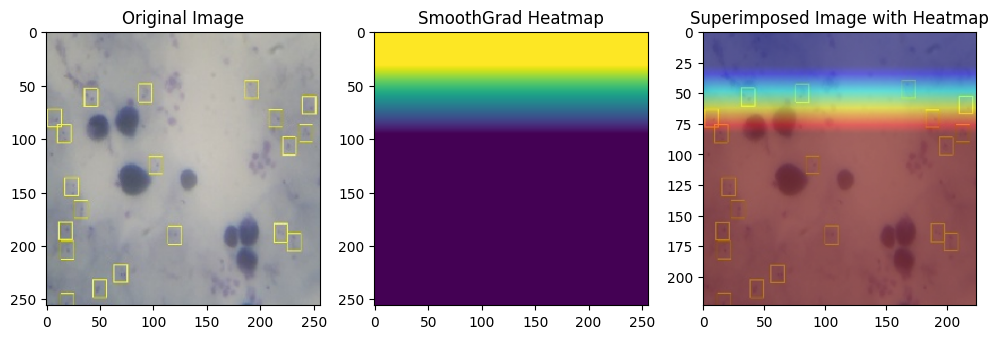

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Function to create SmoothGrad visualization
def create_smooth_grad(img_path, model, last_conv_layer_name="dense_14", n_samples=50, noise_level=0.1):
    img = image.load_img(img_path, target_size=(256, 256))
    x = image.img_to_array(img)
    x = preprocess_input(x)
    x_expanded = np.expand_dims(x, axis=0)

    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])

    smooth_grad = None

    for i in range(n_samples):
        noise = np.random.normal(0, noise_level, x.shape).astype(np.float32)
        noisy_x = x + noise
        noisy_x = np.expand_dims(noisy_x, axis=0)

        with tf.GradientTape() as tape:
            conv_outputs, predictions = grad_model(noisy_x)
            loss = predictions[:, np.argmax(predictions[0])]

        grads = tape.gradient(loss, conv_outputs)[0]

        if smooth_grad is None:
            smooth_grad = grads
        else:
            smooth_grad += grads

    smooth_grad /= n_samples
    smooth_grad = np.mean(smooth_grad, axis=-1)
    smooth_grad = np.maximum(smooth_grad, 0)
    smooth_grad = smooth_grad / smooth_grad.max()
    smooth_grad = cv2.resize(smooth_grad, (256, 256))
    heatmap = cv2.applyColorMap(np.uint8(255 * smooth_grad), cv2.COLORMAP_JET)

    original_img = image.img_to_array(image.load_img(img_path, target_size=(224, 224)))
    heatmap = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0]))
    superimposed_img = cv2.addWeighted(original_img, 0.5, heatmap, 0.5, 0, dtype=cv2.CV_8UC3)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(smooth_grad, cmap='viridis')
    plt.title('SmoothGrad Heatmap')

    plt.subplot(1, 3, 3)
    plt.imshow(superimposed_img / 255.0)
    plt.title('Superimposed Image with Heatmap')

    plt.show()

# Example usage of create_smooth_grad
example_img_path = '/content/drive/MyDrive/DATASETS/Annotated_Folder/train/Positive/plasmodium-0000.jpg'
# model = load_model('/path/to/your/model.h5')
create_smooth_grad(example_img_path, densenet_branch)


In [ ]:
densenet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d_1  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 128)               131200    
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 7168833 (27.35 MB)
Trainable params: 131329 (513.00 KB)
Non-trainable params: 7037504 (26.85 MB)
_________________________________________________________________


In [ ]:
from sklearn.metrics import classification_report, accuracy_score

# Assuming you've already loaded your datasets (mobilenet_branch_X_val, mobilenet_branch_y_val)

# Evaluate the MobileNet model on the validation set
densenet_predictions = densenet_model.predict(densenet_branch_X_val)
densenet_predictions = (densenet_predictions > 0.5).astype(int)  # Convert probabilities to binary predictions

# Calculate metrics
accuracy = accuracy_score(densenet_branch_y_val, densenet_predictions)
classification_report_output = classification_report(densenet_branch_y_val, densenet_predictions, target_names=['Class 0', 'Class 1'])

# Print the metrics
print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:\n', classification_report_output)


2/2 [==============================] - 13s 3s/step
Accuracy: 0.9821
Classification Report:
               precision    recall  f1-score   support

     Class 0       1.00      0.83      0.91         6
     Class 1       0.98      1.00      0.99        50

    accuracy                           0.98        56
   macro avg       0.99      0.92      0.95        56
weighted avg       0.98      0.98      0.98        56



2/2 [==============================] - 9s 3s/step


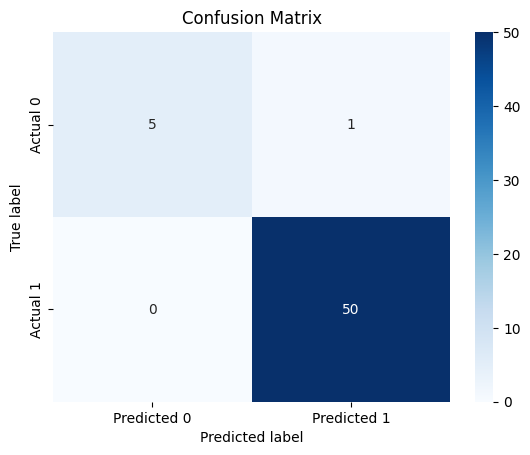

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


densenet_predictions = densenet_model.predict(densenet_branch_X_val)
densenet_predictions = (densenet_predictions > 0.5).astype(int)
conf_matrix = confusion_matrix(densenet_branch_y_val, densenet_predictions)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from tensorflow.keras.models import load_model

mobilenet_model_path = '/content/drive/MyDrive/Resized_Annotated_Folder/densenet1_branch_model.h5'
mobilenet_model = load_model(mobilenet_model_path)

mobilenet_model.summary()

last_layer_name = mobilenet_model.layers[-1].name
print("Last Layer Name:", last_layer_name)


Model: "model_26"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d_4 (ZeroPadd  (None, 230, 230, 3)          0         ['input_4[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d_4[0][0]']    
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']   

In [ ]:
!pip install tf-explain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.4 MB/s eta 0:00:00


In [ ]:
!pip install tf-explain

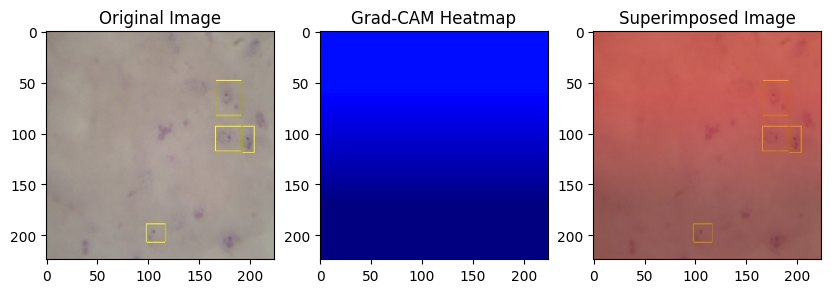

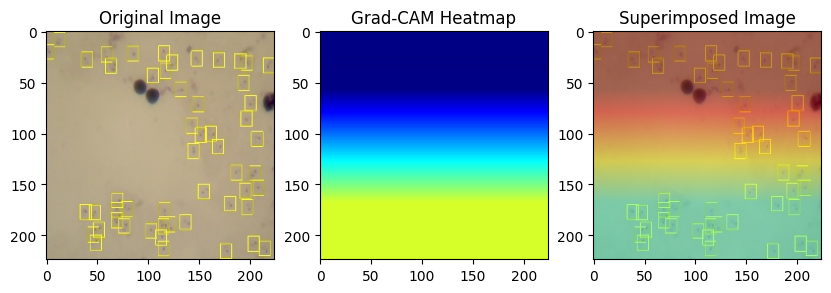

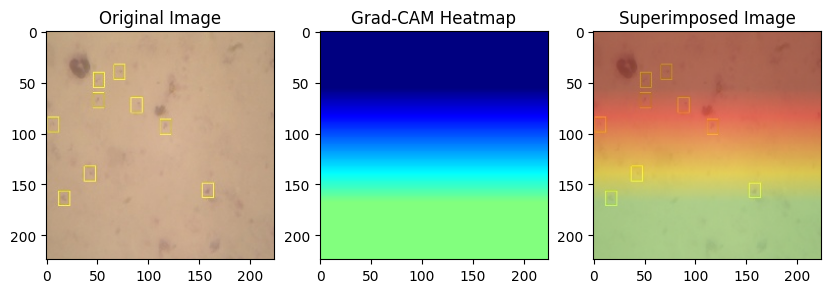

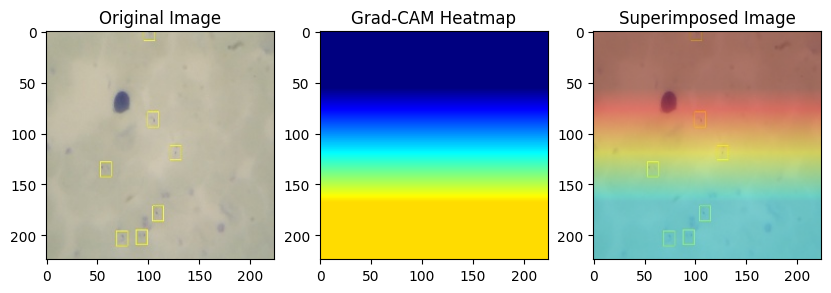

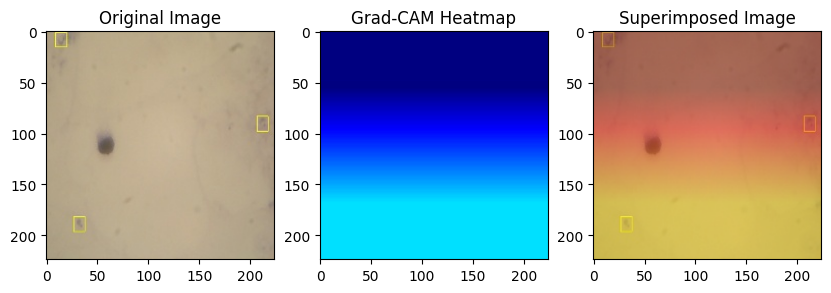

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras.applications.densenet import preprocess_input

densenet_model_path = '/content/drive/MyDrive/Resized_Annotated_Folder/densenet1_branch_model.h5'
densenet_model = load_model(densenet_model_path)

def generate_gradcam(img_path, model, layer_name='dense_5'):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    last_conv_layer = model.get_layer(layer_name)

    grad_model = Model([model.inputs], [last_conv_layer.output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]
    grads = tape.gradient(loss, conv_outputs)[0]

    guided_grads = (grads * tf.cast(conv_outputs > 0, 'float32'))

    weights = tf.reduce_mean(guided_grads, axis=(0, 1))

    cam = np.dot(conv_outputs[0], weights.numpy())
    cam = cv2.resize(cam, (img_array.shape[2], img_array.shape[1]))
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    return cam

dir_path = '/content/drive/MyDrive/Resized_Annotated_Folder/With_Bounding_Boxes'
files = os.listdir(dir_path)[:5]

for file in files:
    img_path = os.path.join(dir_path, file)
    cam = generate_gradcam(img_path, densenet_model)
    original_img = cv2.imread(img_path)
    original_img = cv2.resize(original_img, (224, 224))
    heatmap = cv2.resize(cam, (original_img.shape[1], original_img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(original_img, 0.6, heatmap, 0.4, 0)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(original_img[:, :, ::-1])
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(heatmap)
    plt.title('Grad-CAM Heatmap')

    plt.subplot(1, 3, 3)
    plt.imshow(superimposed_img[:, :, ::-1])
    plt.title('Superimposed Image')

    plt.show()



# Inception -V3

In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

def create_inceptionv3_branch(input_shape=(224, 224, 3), save_path='inceptionv3_branch_model.h5'):
    inceptionv3_model = InceptionV3(input_shape=input_shape, include_top=False, weights='imagenet')
    for layer in inceptionv3_model.layers:
        layer.trainable = False
    model = Sequential()
    model.add(inceptionv3_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.save(save_path)

    return model

# Example usage
# inceptionv3_branch_save_path = '/content/drive/MyDrive/Resized_Annotated_Folder/inceptionv3_branch_model.h5'
# inceptionv3_branch = create_inceptionv3_branch(save_path=inceptionv3_branch_save_path)
# inceptionv3_branch.summary()


In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
num_classes = 1
def create_inceptionv3_branch(input_shape=(256, 256, 3), num_classes=1):
    inceptionv3_model = InceptionV3(input_shape=input_shape, include_top=False, weights='imagenet')

    # Make the last block of the convolutional base trainable
    for layer in inceptionv3_model.layers[:-4]:
        layer.trainable = False

    model = Sequential([
        inceptionv3_model,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    # Compile model
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

# Create the model
model = create_inceptionv3_branch()

# Summarize the model
model.summary()

87910968/87910968 [==============================] - 1s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 global_average_pooling2d_4  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_7 (Dense)             (None, 128)               262272    
                                                                 
 batch_normalization_121 (B  (None, 128)               512       
 atchNormalization)                                              
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                       

In [ ]:
# Define directories for training and validation data
train_dir = '/content/drive/MyDrive/DATASETS/Annotated_Folder/train'
val_dir = '/content/drive/MyDrive/DATASETS/Annotated_Folder/val'

# Data generators for loading images
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input,
    horizontal_flip=True,
    vertical_flip=True
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary'
    #if num_classes == 2 else 'categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary'
    #if num_classes == 2 else 'categorical'
)


# Define callbacks
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

Found 2143 images belonging to 2 classes.
Found 536 images belonging to 2 classes.


In [ ]:
# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[checkpoint, early_stopping]
)

# Load the best model
model.load_weights('best_model.h5')

Epoch 1/10
67/67 [==============================] - 484s 7s/step - loss: 0.5981 - accuracy: 0.8941 - val_loss: 0.4664 - val_accuracy: 0.8937
Epoch 2/10
67/67 [==============================] - 411s 6s/step - loss: 0.3496 - accuracy: 0.8941 - val_loss: 0.2431 - val_accuracy: 0.8937
Epoch 3/10
67/67 [==============================] - 423s 6s/step - loss: 0.2492 - accuracy: 0.8941 - val_loss: 0.2130 - val_accuracy: 0.8937
Epoch 4/10
67/67 [==============================] - 411s 6s/step - loss: 0.2013 - accuracy: 0.8941 - val_loss: 0.2370 - val_accuracy: 0.8937
Epoch 5/10
67/67 [==============================] - 411s 6s/step - loss: 0.1723 - accuracy: 0.8941 - val_loss: 0.2104 - val_accuracy: 0.8937
Epoch 6/10
67/67 [==============================] - 430s 6s/step - loss: 0.1733 - accuracy: 0.8941 - val_loss: 0.1777 - val_accuracy: 0.8937


In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

resnet_model_path = 'best_model.h5'
resnet_model = load_model(resnet_model_path)


dir_path = '/content/drive/MyDrive/DATASETS/Annotated_Folder/train/Positive'
files = os.listdir(dir_path)

for file in files:
    # Full path to the image file
    img_path = os.path.join(dir_path, file)

    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(256, 256))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    last_conv_layer = resnet_model.get_layer("top_activation")
    grad_model = tf.keras.models.Model([resnet_model.inputs], [last_conv_layer.output, resnet_model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(x)
        loss = predictions[:, np.argmax(predictions[0])]
    grads = tape.gradient(loss, conv_outputs)[0]
    weights = tf.reduce_mean(grads, axis=(0, 1))
    cam = np.dot(conv_outputs[0], weights.numpy())
    cam = cv2.resize(cam, (224, 224))
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)

    original_img_uint8 = np.uint8(x[0])
    heatmap_uint8 = np.uint8(heatmap)
    heatmap_uint8 = cv2.resize(heatmap_uint8, (original_img_uint8.shape[1], original_img_uint8.shape[0]))
    superimposed_img = cv2.addWeighted(original_img_uint8, 0.5, heatmap_uint8, 0.5, 0)
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(cam, cmap='viridis')
    plt.title('Grad-CAM Heatmap')

    plt.subplot(1, 3, 3)
    plt.imshow(superimposed_img)
    plt.title('Superimposed Image with Heatmap')

    # Save each visualization with a unique name
    # save_path = os.path.join('/content/drive/MyDrive/grad_cam_visualizations', f'grad_cam_{file}')
    # plt.savefig(save_path)
    # plt.close()  # Close the current figure to free up memory
    plt.show()  # Display the visualization


OSError: No file or directory found at best_model.h5

<ipython-input-26-7da0c82ae9ca>:19: RuntimeWarning: invalid value encountered in divide
  cam = cam / cam.max()
<ipython-input-26-7da0c82ae9ca>:20: RuntimeWarning: invalid value encountered in cast
  heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)


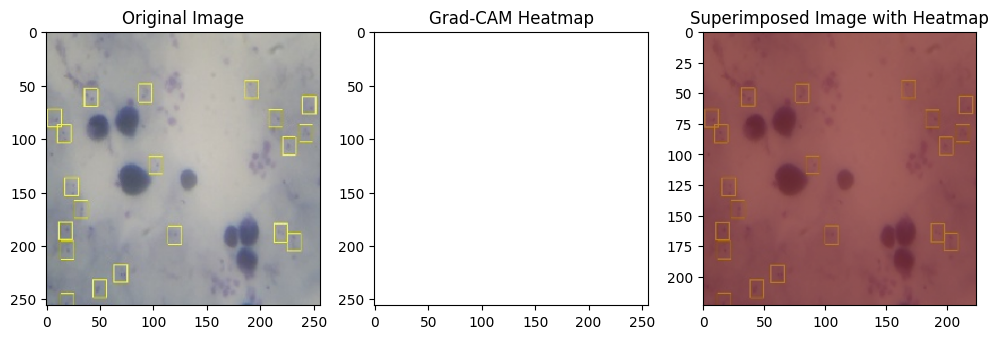

In [ ]:
# Function to create Grad-CAM visualization
def create_grad_cam(img_path, model, last_conv_layer_name="dense_7"):
    img = image.load_img(img_path, target_size=(256, 256))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(x)
        loss = predictions[:, np.argmax(predictions[0])]

    grads = tape.gradient(loss, conv_outputs)[0]
    weights = tf.reduce_mean(grads, axis=(0, ))
    cam = np.dot(conv_outputs[0], weights.numpy())
    cam = cv2.resize(cam, (256, 256))
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)

    original_img = image.img_to_array(image.load_img(img_path, target_size=(224, 224)))
    heatmap = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0]))
    superimposed_img = cv2.addWeighted(original_img, 0.5, heatmap, 0.5, 0, dtype=cv2.CV_8UC3)
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(cam, cmap='viridis')
    plt.title('Grad-CAM Heatmap')

    plt.subplot(1, 3, 3)
    plt.imshow(superimposed_img / 255.0)
    plt.title('Superimposed Image with Heatmap')

    plt.show()

# Example usage of create_grad_cam
example_img_path = '/content/drive/MyDrive/DATASETS/Annotated_Folder/train/Positive/plasmodium-0000.jpg'
create_grad_cam(example_img_path, model)


<ipython-input-27-fbea5d5fadf7>:40: RuntimeWarning: invalid value encountered in scalar divide
  smooth_grad = smooth_grad / smooth_grad.max()
<ipython-input-27-fbea5d5fadf7>:42: RuntimeWarning: invalid value encountered in cast
  heatmap = cv2.applyColorMap(np.uint8(255 * smooth_grad), cv2.COLORMAP_JET)


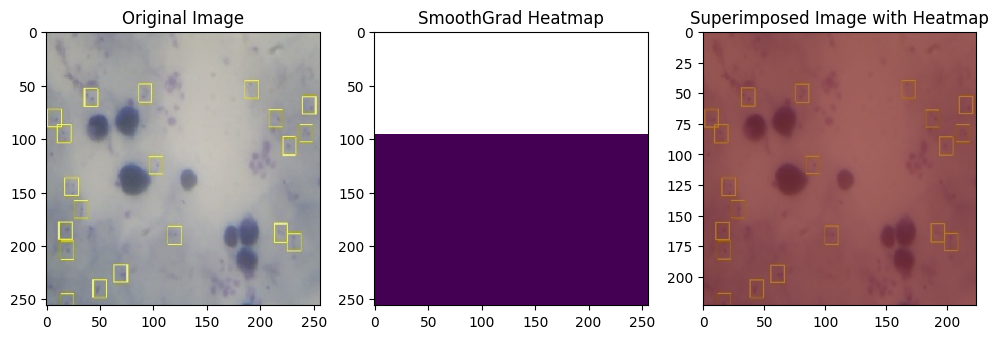

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Function to create SmoothGrad visualization
def create_smooth_grad(img_path, model, last_conv_layer_name="dense_7", n_samples=50, noise_level=0.1):
    img = image.load_img(img_path, target_size=(256, 256))
    x = image.img_to_array(img)
    x = preprocess_input(x)
    x_expanded = np.expand_dims(x, axis=0)

    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])

    smooth_grad = None

    for i in range(n_samples):
        noise = np.random.normal(0, noise_level, x.shape).astype(np.float32)
        noisy_x = x + noise
        noisy_x = np.expand_dims(noisy_x, axis=0)

        with tf.GradientTape() as tape:
            conv_outputs, predictions = grad_model(noisy_x)
            loss = predictions[:, np.argmax(predictions[0])]

        grads = tape.gradient(loss, conv_outputs)[0]

        if smooth_grad is None:
            smooth_grad = grads
        else:
            smooth_grad += grads

    smooth_grad /= n_samples
    smooth_grad = np.mean(smooth_grad, axis=-1)
    smooth_grad = np.maximum(smooth_grad, 0)
    smooth_grad = smooth_grad / smooth_grad.max()
    smooth_grad = cv2.resize(smooth_grad, (256, 256))
    heatmap = cv2.applyColorMap(np.uint8(255 * smooth_grad), cv2.COLORMAP_JET)

    original_img = image.img_to_array(image.load_img(img_path, target_size=(224, 224)))
    heatmap = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0]))
    superimposed_img = cv2.addWeighted(original_img, 0.5, heatmap, 0.5, 0, dtype=cv2.CV_8UC3)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(smooth_grad, cmap='viridis')
    plt.title('SmoothGrad Heatmap')

    plt.subplot(1, 3, 3)
    plt.imshow(superimposed_img / 255.0)
    plt.title('Superimposed Image with Heatmap')

    plt.show()

# Example usage of create_smooth_grad
example_img_path = '/content/drive/MyDrive/DATASETS/Annotated_Folder/train/Positive/plasmodium-0000.jpg'
# model = load_model('/path/to/your/model.h5')
create_smooth_grad(example_img_path, model)


## Inception-V3 version1

In [ ]:

inceptionv3_branch_X_train = X_train
inceptionv3_branch_y_train = y_train
inceptionv3_branch_X_val = X_val
inceptionv3_branch_y_val = y_val

inceptionv3_model_path = '/content/drive/MyDrive/Resized_Annotated_Folder/inceptionv3_branch_model.h5'
inceptionv3_model = load_model(inceptionv3_model_path)
inceptionv3_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
inceptionv3_model.fit(inceptionv3_branch_X_train, inceptionv3_branch_y_train, validation_data=(inceptionv3_branch_X_val, inceptionv3_branch_y_val), epochs=10, batch_size=32)


Epoch 1/10
8/8 [==============================] - 48s 5s/step - loss: 17.9772 - accuracy: 0.7018 - val_loss: 16.1841 - val_accuracy: 0.8929
Epoch 2/10
8/8 [==============================] - 35s 4s/step - loss: 13.9292 - accuracy: 0.8947 - val_loss: 9.3439 - val_accuracy: 0.8929
Epoch 3/10
8/8 [==============================] - 36s 5s/step - loss: 5.4646 - accuracy: 0.8947 - val_loss: 1.1937 - val_accuracy: 0.8929
Epoch 4/10
8/8 [==============================] - 35s 4s/step - loss: 1.7060 - accuracy: 0.7588 - val_loss: 1.1454 - val_accuracy: 0.8929
Epoch 5/10
8/8 [==============================] - 37s 5s/step - loss: 1.5672 - accuracy: 0.8947 - val_loss: 0.8525 - val_accuracy: 0.9286
Epoch 6/10
8/8 [==============================] - 35s 4s/step - loss: 1.4859 - accuracy: 0.7939 - val_loss: 1.0590 - val_accuracy: 0.9107
Epoch 7/10
8/8 [==============================] - 39s 5s/step - loss: 1.1314 - accuracy: 0.9079 - val_loss: 0.7470 - val_accuracy: 0.9286
Epoch 8/10
8/8 [===============

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

inception_predictions = inceptionv3_model.predict(inceptionv3_branch_X_val)
inception_predictions = (inception_predictions > 0.5).astype(int)
# Calculate metrics
accuracy = accuracy_score(inceptionv3_branch_y_val, inception_predictions)
classification_report_output = classification_report(inceptionv3_branch_y_val, inception_predictions, target_names=['Class 0', 'Class 1'])

# Print the metrics
print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:\n', classification_report_output)


2/2 [==============================] - 8s 4s/step
Accuracy: 0.9464
Classification Report:
               precision    recall  f1-score   support

     Class 0       1.00      0.50      0.67         6
     Class 1       0.94      1.00      0.97        50

    accuracy                           0.95        56
   macro avg       0.97      0.75      0.82        56
weighted avg       0.95      0.95      0.94        56



2/2 [==============================] - 6s 2s/step


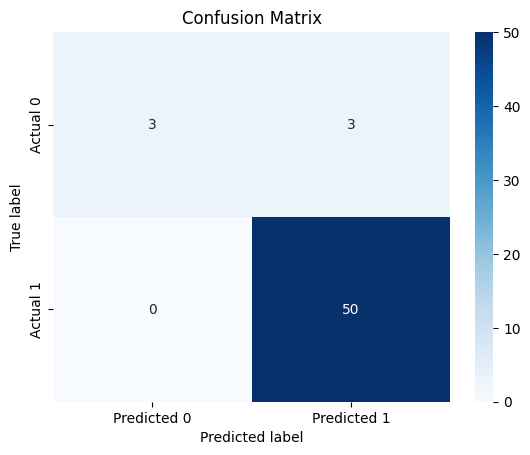

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


inception_predictions = inceptionv3_model.predict(inceptionv3_branch_X_val)
inception_predictions = (inception_predictions > 0.5).astype(int)  # Convert probabilities to binary predictions

# Calculate the confusion matrix
conf_matrix = confusion_matrix(inceptionv3_branch_y_val, inception_predictions)

# Plot the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from tensorflow.keras.models import load_model

inception_model_path = '/content/drive/MyDrive/Resized_Annotated_Folder/inceptionv3_branch_model.h5'
inception_model = load_model(inception_model_path)

inception_model.summary()

last_layer_name = inception_model.layers[-1].name
print("Last Layer Name:", last_layer_name)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_4 (Dense)             (None, 128)               262272    
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 22065185 (84.17 MB)
Trainable params: 262401 (1.00 MB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________
Last Layer Name: dense_5


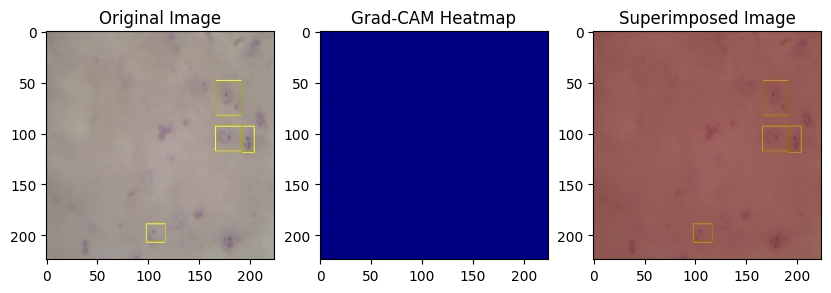

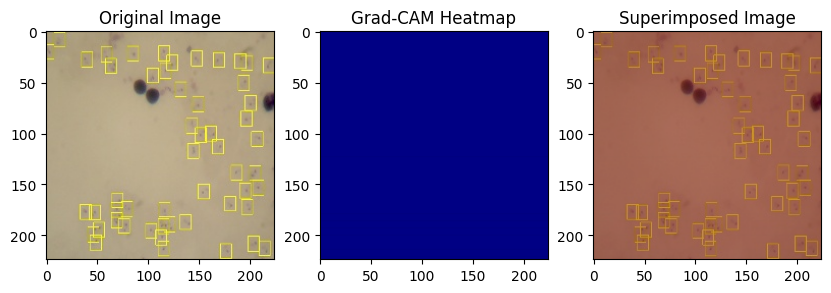

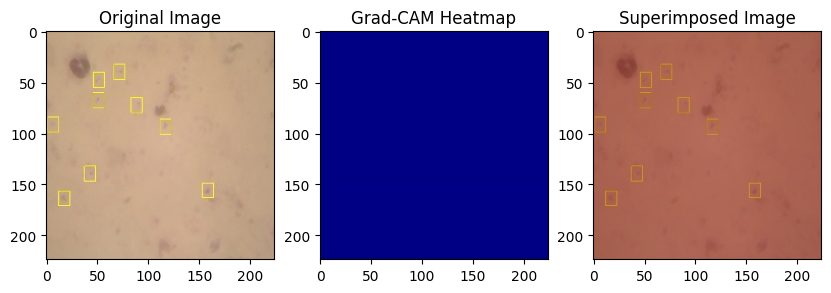

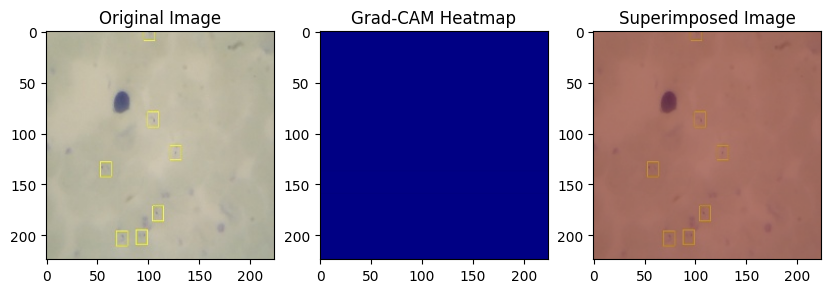

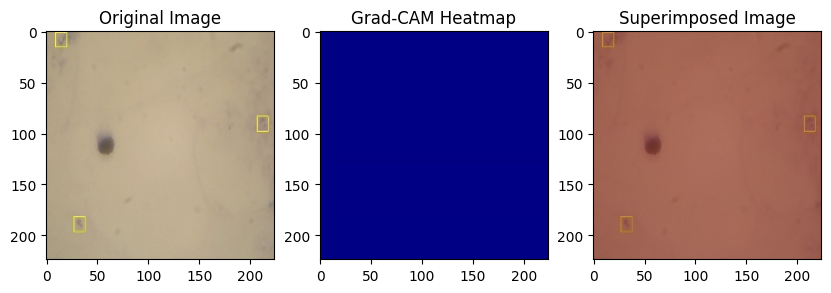

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import preprocess_input

# Load Inception-v3 model
inception_model_path = '/content/drive/MyDrive/Resized_Annotated_Folder/inceptionv3_branch_model.h5'
inception_model = load_model(inception_model_path)

# Ensure the model is compiled
inception_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

def generate_gradcam(img_path, model, layer_name='dense_5'):
    img = image.load_img(img_path, target_size=(224, 224))  # Adjust target size to match the model's expected input size
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    last_conv_layer = model.get_layer(layer_name)
    model = Model(model.inputs, [last_conv_layer.output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = model(img_array)
        loss = predictions[:, 0]

    grads = tape.gradient(loss, conv_outputs)[0]
    guided_grads = (grads * tf.cast(conv_outputs > 0, 'float32'))

    weights = tf.reduce_mean(guided_grads, axis=(0, 1))
    cam = np.dot(conv_outputs[0], weights.numpy())
    cam = cv2.resize(cam, (img_array.shape[2], img_array.shape[1]))
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    return cam

dir_path = '/content/drive/MyDrive/Resized_Annotated_Folder/With_Bounding_Boxes'
files = os.listdir(dir_path)[:5]

for file in files:
    img_path = os.path.join(dir_path, file)
    cam = generate_gradcam(img_path, inception_model)
    original_img = cv2.imread(img_path)
    original_img = cv2.resize(original_img, (224, 224))  # Adjust size to match the model's expected input size
    heatmap = cv2.resize(cam, (original_img.shape[1], original_img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(original_img, 0.6, heatmap, 0.4, 0)
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(original_img[:, :, ::-1])
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(heatmap)
    plt.title('Grad-CAM Heatmap')

    plt.subplot(1, 3, 3)
    plt.imshow(superimposed_img[:, :, ::-1])
    plt.title('Superimposed Image')

    plt.show()


# UNET Architecture


In [ ]:
!pip install tensorflow

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization

def simple_unet_model(input_shape=(224, 224, 3)):
    inputs = Input(shape=input_shape)

    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottom of the U
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)

    # Decoder with skip connections
    up5 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv4)
    up5 = concatenate([up5, conv3], axis=-1)
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(up5)
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(conv5)

    up6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv5)
    up6 = concatenate([up6, conv2], axis=-1)
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(conv6)

    up7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv6)
    up7 = concatenate([up7, conv1], axis=-1)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(conv7)

    # Output layer
    outputs = Conv2D(1, 1, activation='sigmoid')(conv7)
    model = Model(inputs=inputs, outputs=outputs)

    return model

# Create the simplified U-Net model
simple_model = simple_unet_model(input_shape=(224, 224, 3))

# Print the model summary
simple_model.summary()

# Save the model
simple_model.save('/content/drive/MyDrive/Resized_Annotated_Folder/simple_unet_model.h5')


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_66 (Conv2D)          (None, 224, 224, 64)         1792      ['input_7[0][0]']             
                                                                                                  
 conv2d_67 (Conv2D)          (None, 224, 224, 64)         36928     ['conv2d_66[0][0]']           
                                                                                                  
 max_pooling2d_12 (MaxPooli  (None, 112, 112, 64)         0         ['conv2d_67[0][0]']           
 ng2D)                                                                                      